<a href="https://colab.research.google.com/github/dannynew111/erp-clustering-smart-meter-data/blob/main/advanced_stats_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Setup and Load Data

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import all libraries required for advanced statistical tests, predictive modeling,
# and final, publication-quality visualisations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
pd.options.display.float_format = '{:.2f}'.format

# Load the final, clean dataset produced by the clustering notebook.
# This dataset includes the assigned persona labels for each household.
data_loaded_dir = '/content/drive/MyDrive/ERP/data_loaded/'
report_ready_path = os.path.join(data_loaded_dir, 'LCL_Report_Ready_Dataset.csv')
print("Loading the report-ready dataset...")
df = pd.read_csv(report_ready_path)

#  Define Persona Order and Colours for Consistency
persona_order = ['Contrarians', 'Engaged Shifters', 'Low-Volatility Consumers', 'Structurally Constrained']
df['persona_name'] = pd.Categorical(df['persona_name'], categories=persona_order, ordered=True)
persona_colours = {
    'Engaged Shifters': '#1f77b4',
    'Structurally Constrained': '#ff7f0e',
    'Contrarians': '#d62728',
    'Low-Volatility Consumers': '#9467bd'
}
print("Dataset loaded and prepared.")

Mounted at /content/drive
Loading the report-ready dataset...
Dataset loaded and prepared.


In [ ]:
# Engineering Composite Attitudinal Scores

# To create the Strategic Persona Map, I first need to engineer two composite scores
# from the survey data that represent underlying psychological traits.
print("\n Creating composite trait scores ")

# The 'trait_constraint_score' is the mean of four survey items that measure
# a household's perceived lifestyle rigidity and inflexibility.

constraint_cols = [
    'Limited by Being Away From Home',
    'Limited by Inflexible Work Schedule',
    "Limited by Children's Routines",
    'Limited by Fixed Household Habits'
]
df['trait_constraint_score'] = df[constraint_cols].mean(axis=1)
print("Created 'trait_constraint_score'.")

# The 'trait_engagement_score' is a net score measuring overall willingness to engage.
# It is calculated by subtracting the average score of convenience-focused items
# from the average score of positive, proactive attitude items.
positive_attitude_cols = ['Felt More in Control of Bill', 'Planned Energy Use Around Tariffs', 'Desire to Remain on Tariff']
negative_attitude_cols = ['Prioritised Convenience', 'Perceived Inconvenience of Shifting']
df['trait_engagement_score'] = df[positive_attitude_cols].mean(axis=1) - df[negative_attitude_cols].mean(axis=1)
print("Created 'trait_engagement_score'.")



 Creating composite trait scores 
Created 'trait_constraint_score'.
Created 'trait_engagement_score'.



 Visualizing new trait scores 


/tmp/ipython-input-619027171.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='persona_name', y='trait_constraint_score', data=df, palette=persona_colours, order=persona_order)
/tmp/ipython-input-619027171.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='persona_name', y='trait_engagement_score', data=df, palette=persona_colours, order=persona_order)


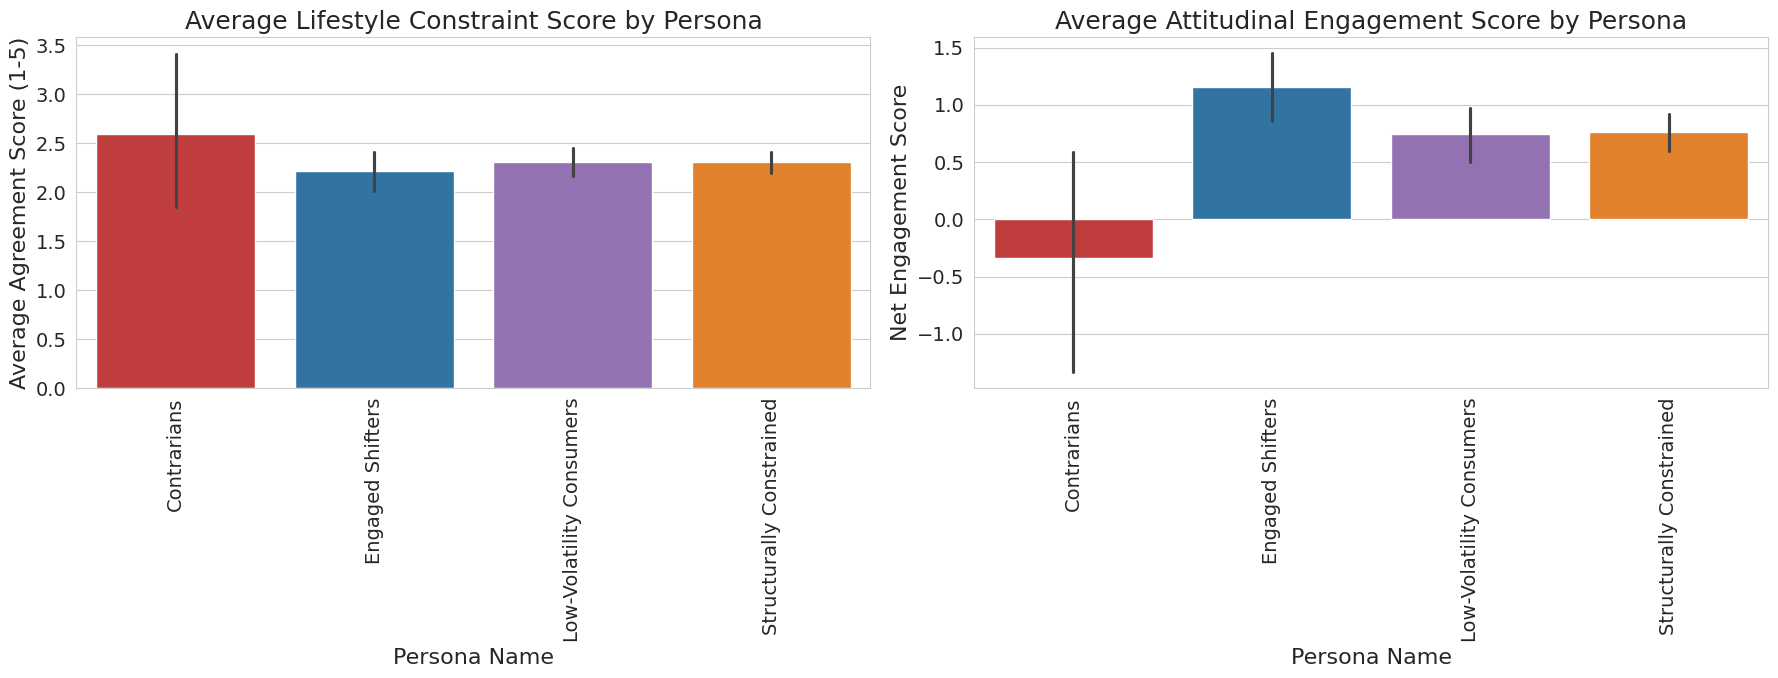

In [ ]:
# Plotting Trait Scores by Persona
print("\n Visualising new trait scores ")

plt.figure(figsize=(18, 7))

# Plot Constraint Score
plt.subplot(1, 2, 1)
sns.barplot(x='persona_name', y='trait_constraint_score', data=df, palette=persona_colours, order=persona_order)
plt.title('Average Lifestyle Constraint Score by Persona')
plt.ylabel('Average Agreement Score (1-5)')
plt.xlabel('Persona Name')
plt.xticks(rotation=90)

# Plot Engagement Score
plt.subplot(1, 2, 2)
sns.barplot(x='persona_name', y='trait_engagement_score', data=df, palette=persona_colours, order=persona_order)
plt.title('Average Attitudinal Engagement Score by Persona')
plt.ylabel('Net Engagement Score')
plt.xlabel('Persona Name')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



 Building a predictive model to identify drivers of behavior 
Feature set correctly created with 36 features.
The following columns were successfully excluded from the model:
['Household_id', 'persona', 'persona_name', 'peak_reduction_weekday', 'peak_reduction_pct_weekday', 'load_shift_weekday', 'peak_reduction_weekend', 'peak_reduction_pct_weekend', 'estimated_cost_savings_pct', 'economic_rationality_score', 'trial_weekday_high', 'trial_weekday_low', 'trial_weekday_normal', 'trial_weekend_high', 'trial_weekend_low', 'trial_weekend_normal']

Missing values before imputation in top 5 columns:
Has Fixed Routine for Tumble Dryer     791
Self-Reported Shift of Tumble Dryer    768
Has Fixed Routine for Dishwasher       767
Self-Reported Shift of Dishwasher      738
Limited by Inflexible Work Schedule    568
dtype: int64

Missing values handled via median imputation.


/tmp/ipython-input-1319019311.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)



Model Accuracy on Test Set: 55.52%
Model OOB (Out-of-Bag) Score: 59.55%

 Generating CORRECTED feature importance plot 


/tmp/ipython-input-1319019311.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(20), y=feature_importances.head(20).index, palette='viridis')


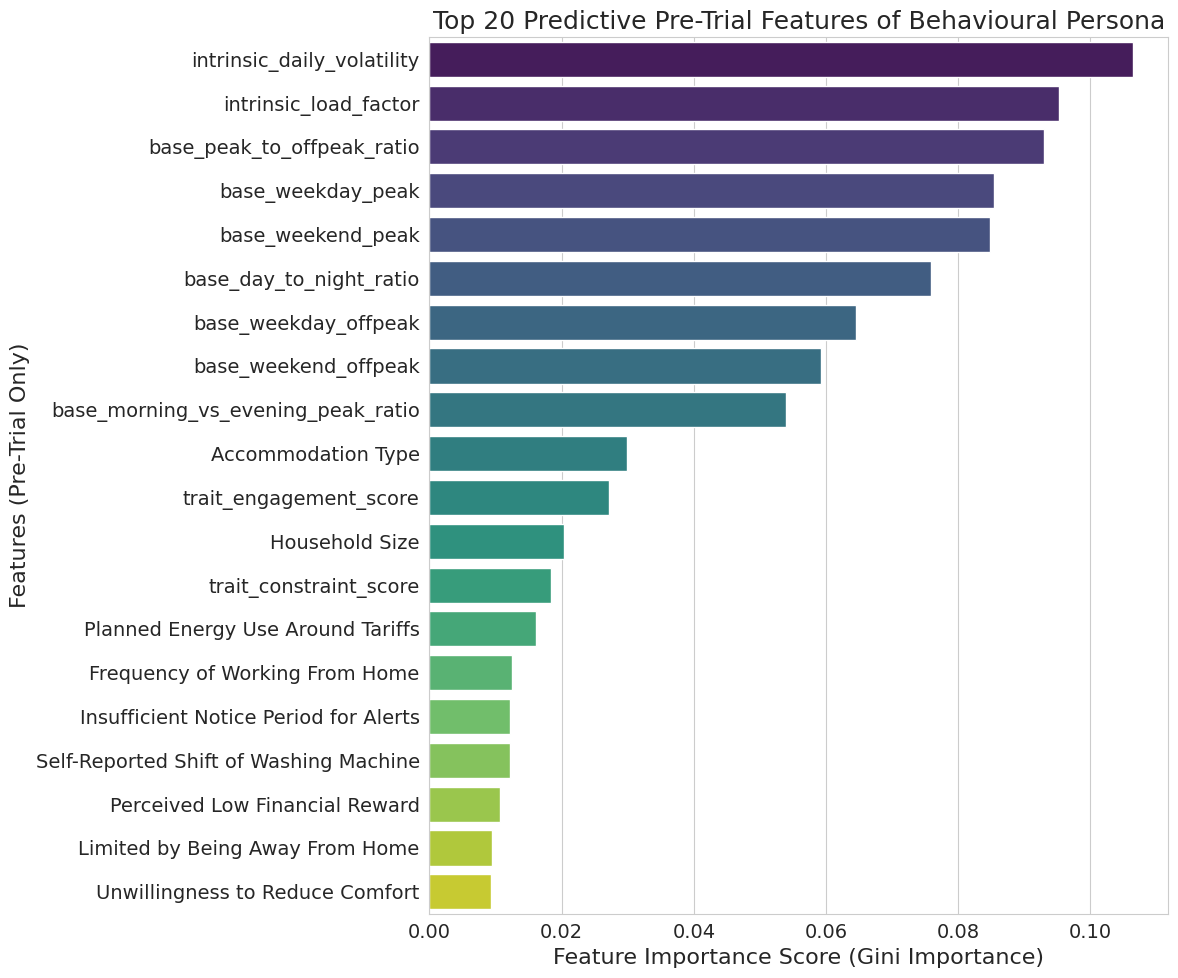

In [ ]:
# Predictive Modeling for Persona Validation

# This is a key validation step for the report. The goal is to build a model that
# predicts persona membership using *only* pre-trial features (intrinsic habits,
# demographics, and survey responses) to see if the personas are rooted in
# pre-existing, identifiable characteristics.
print("\n Building a predictive model to identify drivers of behaviour ")

#  Prepare data for the model

# Subsection 3a: Prepare data for the model
# To prevent data leakage, it is absolutely essential to exclude any feature
# that is an outcome of the trial itself. The model must not see the "answers".
columns_to_exclude = [
    #  Identifiers and Targets
    'Household_id',
    'persona', # The target variable itself
    'persona_name',

    #  Responsiveness Features (Trial Outcomes)
    'peak_reduction_weekday',
    'peak_reduction_pct_weekday',
    'load_shift_weekday',
    'peak_reduction_weekend',
    'peak_reduction_pct_weekend',

    #  Financial Features (Trial Outcomes)
    'estimated_cost_savings_pct',
    'economic_rationality_score',
    #  Trial Period Consumption Features (From Profiling Tables)
    'trial_weekday_high',
    'trial_weekday_low',
    'trial_weekday_normal',
    'trial_weekend_high',
    'trial_weekend_low',
    'trial_weekend_normal'

]

# Define the target variable (y) and the feature set (X)
y = df['persona_name']

# The feature set X is the original dataframe minus all excluded columns
X = df.drop(columns=columns_to_exclude, errors='ignore').copy()

print(f"Feature set correctly created with {X.shape[1]} features.")
print("The following columns were successfully excluded from the model:")
print([col for col in columns_to_exclude if col in df.columns]) # Show which ones were actually found and dropped


# Subsection 3b: Handle missing values
# Some survey or demographic data may be missing. I am using median imputation
# because it is simple and robust to outliers.
print(f"\nMissing values before imputation in top 5 columns:\n{X.isnull().sum().sort_values(ascending=False).head()}")
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)
print("\nMissing values handled via median imputation.")


# Subsection 3c: Train and Evaluate the Random Forest Model

# The data is split into training and testing sets. 'stratify=y' is crucial
# here to ensure the proportion of each persona is the same in both sets,
# which is important for training on imbalanced data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# I chose a RandomForestClassifier. The two most important parameters are:
# 'class_weight='balanced'': This adjusts model weights to be inversely proportional
# to class frequencies. It penalizes the model more for misclassifying the smaller
# persona groups ('Contrarians', 'Engaged Shifters'), forcing it to learn them.
# 'random_state=42': Ensures the model is fully reproducible.
model = RandomForestClassifier(n_estimators=150, random_state=42, oob_score=True, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate the model's performance on unseen data.
print(f"\nModel Accuracy on Test Set: {accuracy_score(y_test, model.predict(X_test)):.2%}")

# The Out-of-Bag (OOB) score is a reliable accuracy estimate calculated using trees
# that did not see a particular data point during training.
print(f"Model OOB (Out-of-Bag) Score: {model.oob_score_:.2%}")


# Section 4: Visualising Model Insights and Strategic Tools
#Feature Importance Plot

# This plot visualises the output of the trained model, showing which pre-trial
# features were the most powerful predictors of persona membership.
print("\n Generating CORRECTED feature importance plot ")
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances.head(20), y=feature_importances.head(20).index, palette='viridis')
plt.title('Top 20 Predictive Pre-Trial Features of Behavioural Persona')
plt.xlabel('Feature Importance Score (Gini Importance)')
plt.ylabel('Features (Pre-Trial Only)')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1767776392.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_persona_traits = df.groupby('persona_name')[['trait_constraint_score', 'trait_engagement_score']].mean().reset_index()


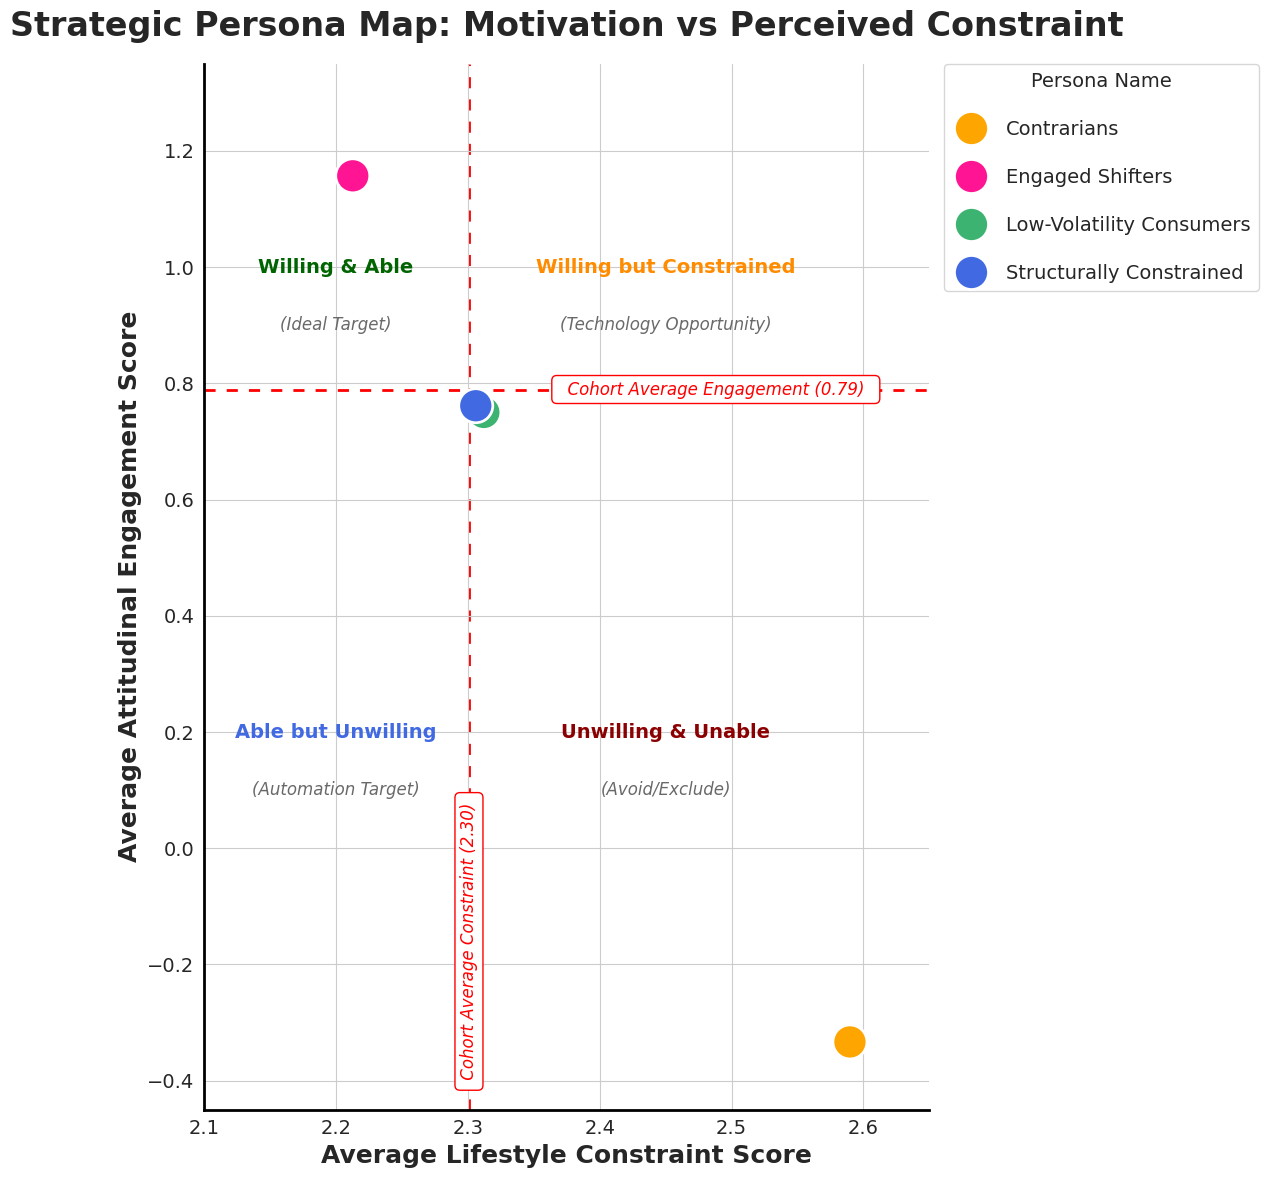

In [ ]:
# Subsection 4b: Strategic Persona Map (Motivation vs. Constraint)

# This is a key original contribution of the project. It maps the four personas
# onto a 2x2 grid based on their average scores for the two composite traits.

# First, prepare the data by calculating the average trait scores for each persona.
df_persona_traits = df.groupby('persona_name')[['trait_constraint_score', 'trait_engagement_score']].mean().reset_index()
# The dividing lines for the quadrants are the cohort-wide averages, making them data-driven.
avg_constraint = df['trait_constraint_score'].mean()
avg_engagement = df['trait_engagement_score'].mean()

#  Define the colour palette
strategic_palette = {
    'Engaged Shifters': 'deeppink',
    'Contrarians': 'orange',
    'Low-Volatility Consumers': 'mediumseagreen',
    'Structurally Constrained': 'royalblue'
}

# Create the scatter plot, where each point represents a persona.
fig, ax = plt.subplots(figsize=(14, 12))
sns.set_style("whitegrid")

# Create the scatter plot
sns.scatterplot(
    x='trait_constraint_score',
    y='trait_engagement_score',
    data=df_persona_traits,
    hue='persona_name',
    hue_order=persona_order,
    palette=strategic_palette,
    s=600,
    legend='full',
    ax=ax,
    zorder=10
)

#  Customise Legend
legend = ax.legend(
    title='Persona Name', title_fontsize='14', bbox_to_anchor=(1.02, 1),
    loc='upper left', borderaxespad=0., fontsize='14',
    labelspacing=1.5
)

#  # Add the data-driven quadrant divider lines.
ax.axhline(avg_engagement, color='red', linestyle='--', linewidth=2, dashes=(4, 4), zorder=0)
ax.axvline(avg_constraint, color='red', linestyle='--', linewidth=2, dashes=(4, 4), zorder=0)

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1)
ax.text(ax.get_xlim()[1], avg_engagement, f'  Cohort Average Engagement ({avg_engagement:.2f})  ',
        ha='right', va='center', fontsize=12, style='italic', color='red',
        bbox=bbox_props)
ax.text(avg_constraint, ax.get_ylim()[0], f' Cohort Average Constraint ({avg_constraint:.2f}) ',
        ha='center', va='bottom', fontsize=12, style='italic', color='red',
        bbox=bbox_props, rotation=90)

# Add polished labels to define and interpret each quadrant.
quadrant_title_props = dict(fontsize=14, weight='bold', ha='center', va='center')
quadrant_subtitle_props = dict(fontsize=12, style='italic', ha='center', va='center', color='dimgray')

ax.text(2.45, 1.0, 'Willing but Constrained', color='darkorange', **quadrant_title_props)
ax.text(2.45, 0.90, '(Technology Opportunity)', **quadrant_subtitle_props)

ax.text(2.20, 1.0, 'Willing & Able', color='darkgreen', **quadrant_title_props)
ax.text(2.20, 0.90, '(Ideal Target)', **quadrant_subtitle_props)

ax.text(2.20, 0.2, 'Able but Unwilling', color='royalblue', **quadrant_title_props)
ax.text(2.20, 0.1, '(Automation Target)', **quadrant_subtitle_props)

ax.text(2.45, 0.2, 'Unwilling & Unable', color='darkred', **quadrant_title_props)
ax.text(2.45, 0.1, '(Avoid/Exclude)', **quadrant_subtitle_props)

#  Final Styling: Titles and Formal Axis Labels
ax.set_title('Strategic Persona Map: Motivation vs Perceived Constraint', fontsize=24, weight='bold', pad=20)
ax.set_xlabel('Average Lifestyle Constraint Score', fontsize=18, weight='bold')
ax.set_ylabel('Average Attitudinal Engagement Score', fontsize=18, weight='bold')


ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#  Manually set axis limits and ticks
ax.set_xlim(2.10, 2.65)
ax.set_ylim(-0.45, 1.35)
ax.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout to make space for the legend
fig.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


Generating Demographic Profile plots


/tmp/ipython-input-2549505380.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


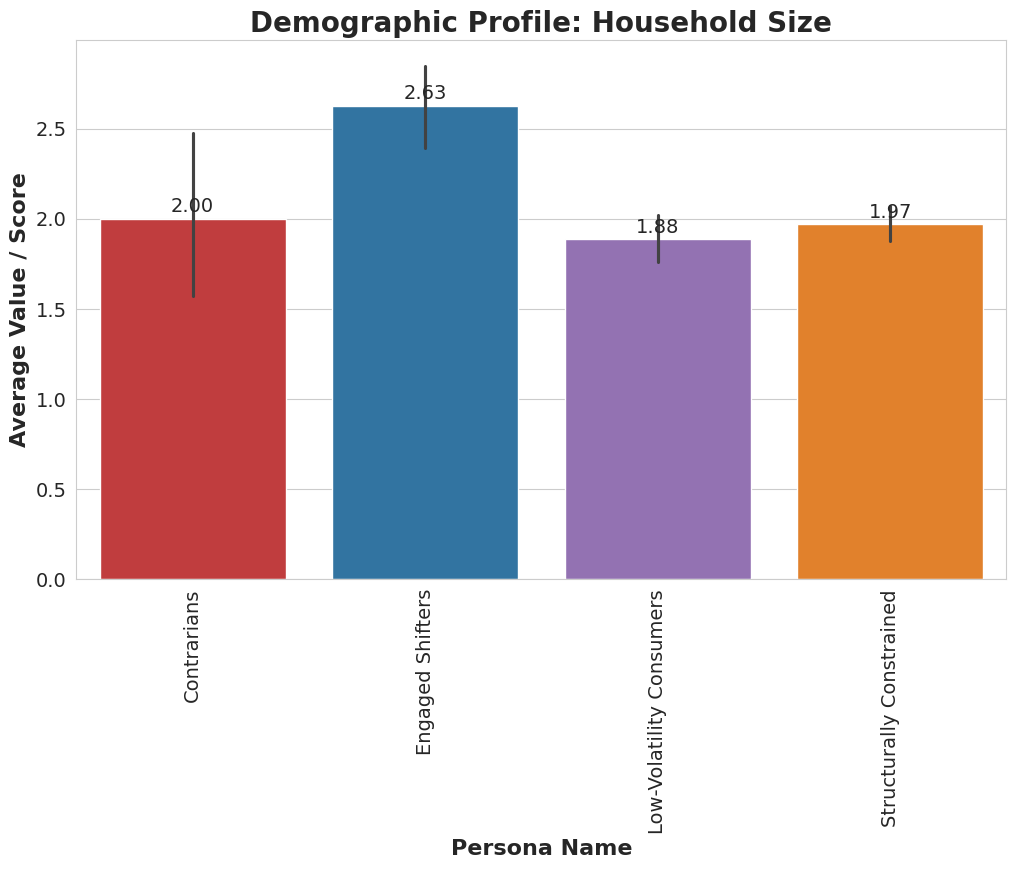

/tmp/ipython-input-2549505380.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


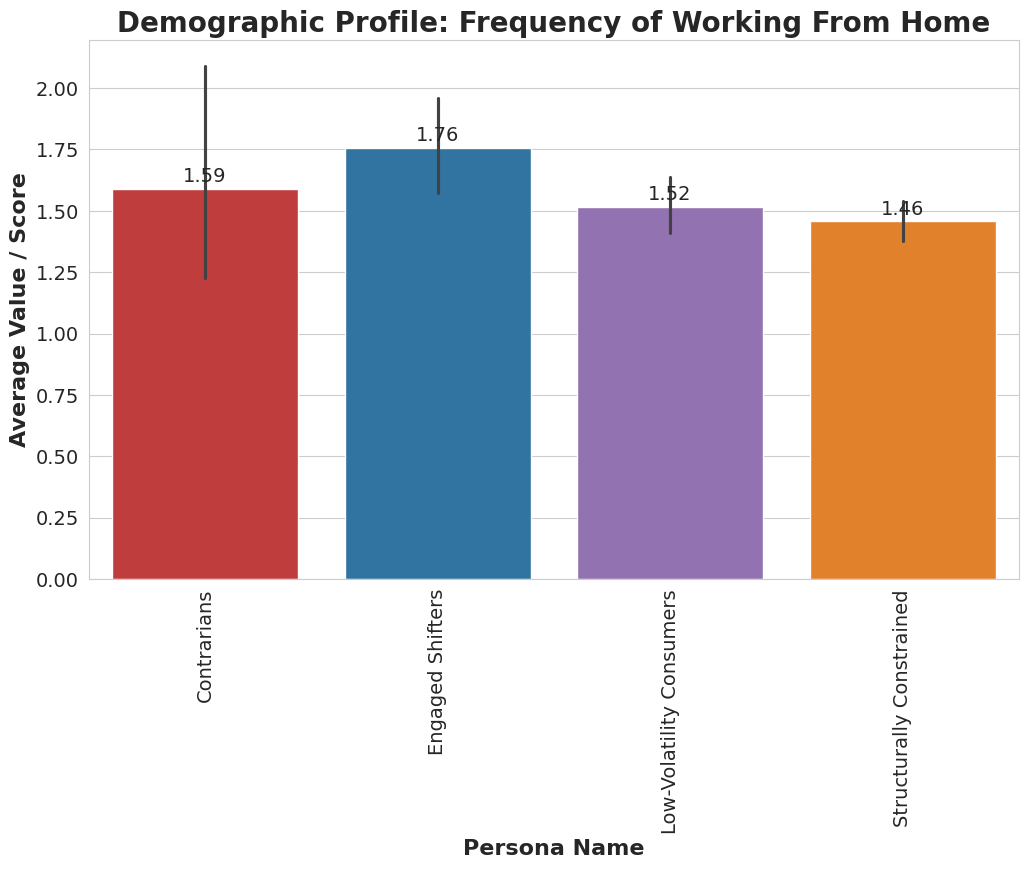

/tmp/ipython-input-2549505380.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


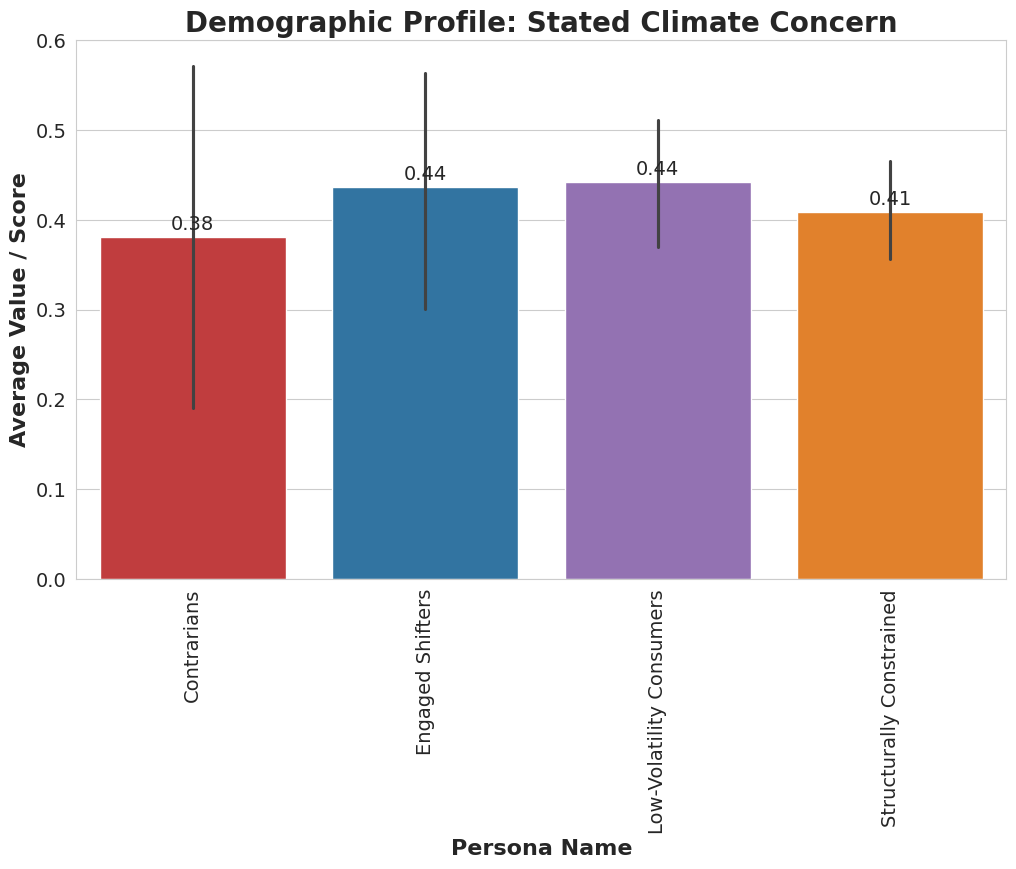

/tmp/ipython-input-2549505380.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


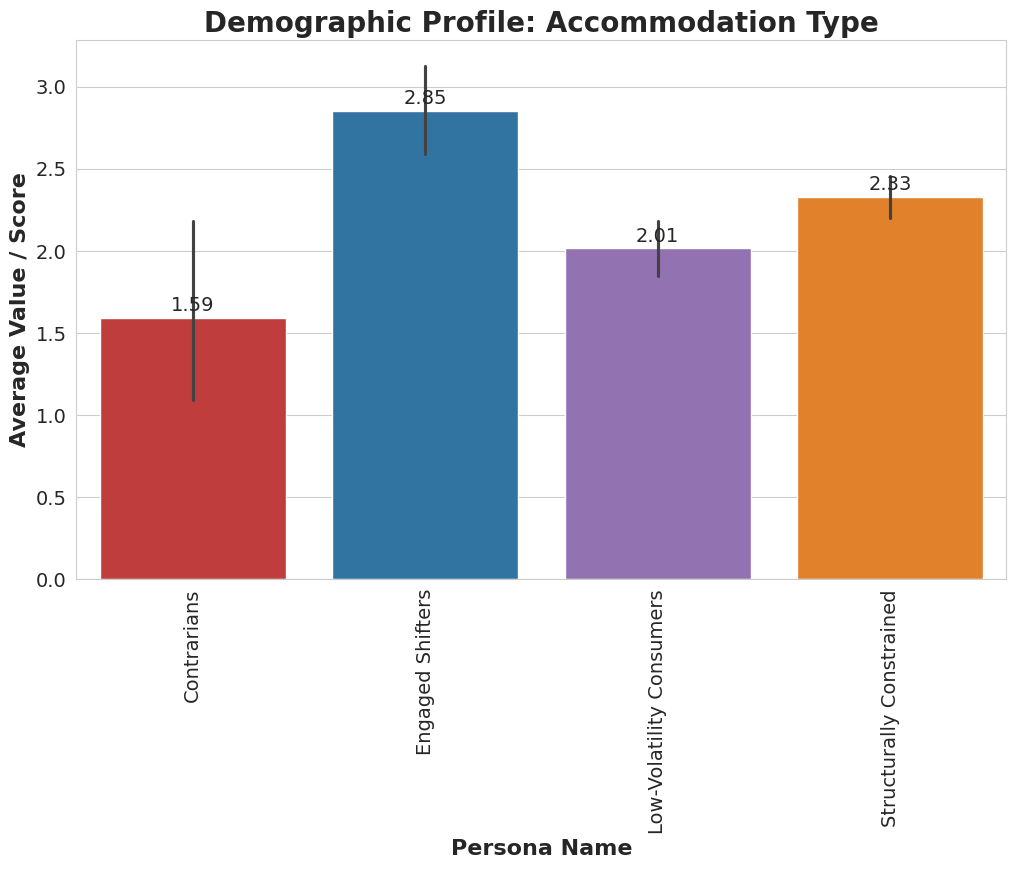

In [ ]:
# Section 5: Detailed Persona Deep-Dive Visualisations

# This final section generates a series of detailed plots to add further evidence
# and narrative texture to each persona's profile

# Subsection 5a: Demographic Profiles

#  Set a consistent plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

print("\nGenerating Demographic Profile plots")

demographic_features = {
    'Household Size': 'Household Size',
    'Frequency of Working From Home': 'Frequency of Working From Home',
    'Stated Climate Concern': 'Stated Climate Concern',
    'Accommodation Type': 'Accommodation Type'
}

for col, title in demographic_features.items():
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)
    ax.set_title(f'Demographic Profile: {title}', weight='bold')
    ax.set_xlabel('Persona Name', weight='bold')
    ax.set_ylabel('Average Value / Score', weight='bold')
    plt.xticks(rotation=90)

    # Add data labels to the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')
    plt.show()


Generating Perceived Barriers Heatmap


/tmp/ipython-input-1386049080.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  barrier_data = df.groupby('persona_name')[barrier_cols].mean().reindex(persona_order)


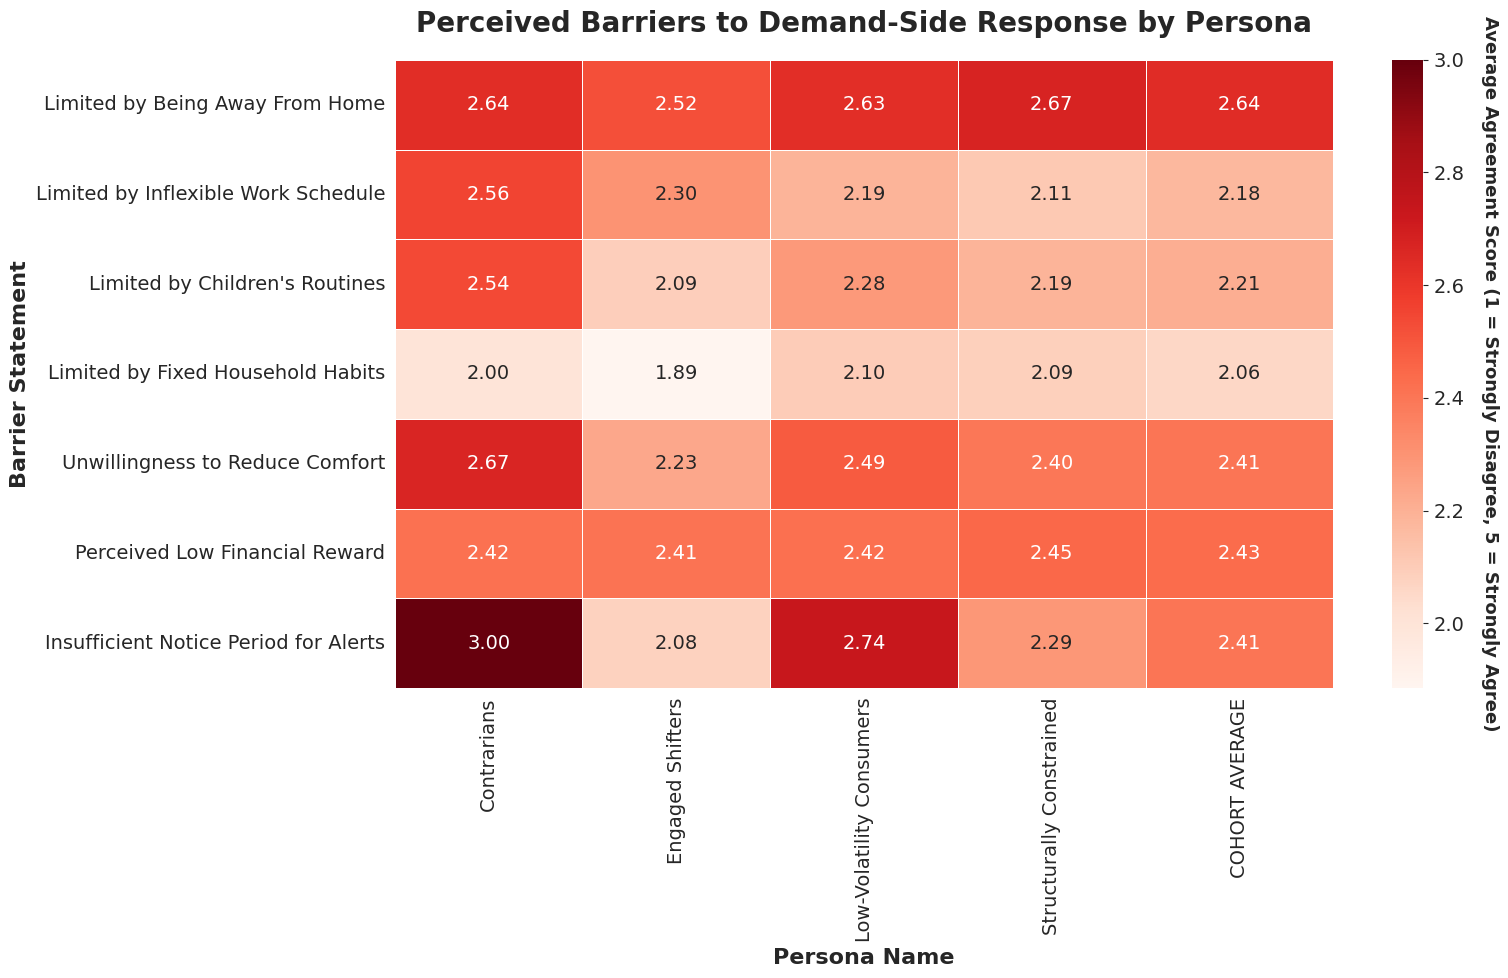

In [ ]:
# Subsection 5b: Perceived Barriers Heatmap
# This heatmap visually compares the average agreement score for each barrier
# across all four personas and the cohort average.

print("\nGenerating Perceived Barriers Heatmap")

barrier_cols = [
    'Limited by Being Away From Home', 'Limited by Inflexible Work Schedule',
    "Limited by Children's Routines", 'Limited by Fixed Household Habits',
    'Unwillingness to Reduce Comfort', 'Perceived Low Financial Reward',
    'Insufficient Notice Period for Alerts'
]

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(16, 10))

# Calculate the average agreement score for each barrier by persona
barrier_data = df.groupby('persona_name')[barrier_cols].mean().reindex(persona_order)
barrier_data.loc['COHORT AVERAGE'] = df[barrier_cols].mean()

heatmap = sns.heatmap(
    barrier_data.T,
    annot=True,
    fmt=".2f",
    cmap='Reds',
    linewidths=.5,
    ax=ax
)

#  Manually adjust colour bar label as wasn't fitting on screen before
cbar = heatmap.collections[0].colorbar
cbar.set_label(
    'Average Agreement Score (1 = Strongly Disagree, 5 = Strongly Agree)',
    rotation=270, # Rotate the label to be horizontal
    labelpad=25,   # Move the label further away from the color bar
    fontsize=13,    # adjusted font size
    fontweight='bold'  #makes label bold
)


ax.set_title('Perceived Barriers to Demand-Side Response by Persona', weight='bold', pad=20, fontsize=20)
ax.set_xlabel('Persona Name', weight='bold', fontsize=16)
ax.set_ylabel('Barrier Statement', weight='bold', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)

# Use tight_layout as a final polish, now that the main issue is solved
plt.tight_layout()
plt.show()


[3] Generating Attitude Comparison plots...


/tmp/ipython-input-1230192281.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('persona_name')[list(positive_factors.keys())].mean().reindex(persona_order).plot(
/tmp/ipython-input-1230192281.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('persona_name')[list(disengagement_factors.keys())].mean().reindex(persona_order).plot(


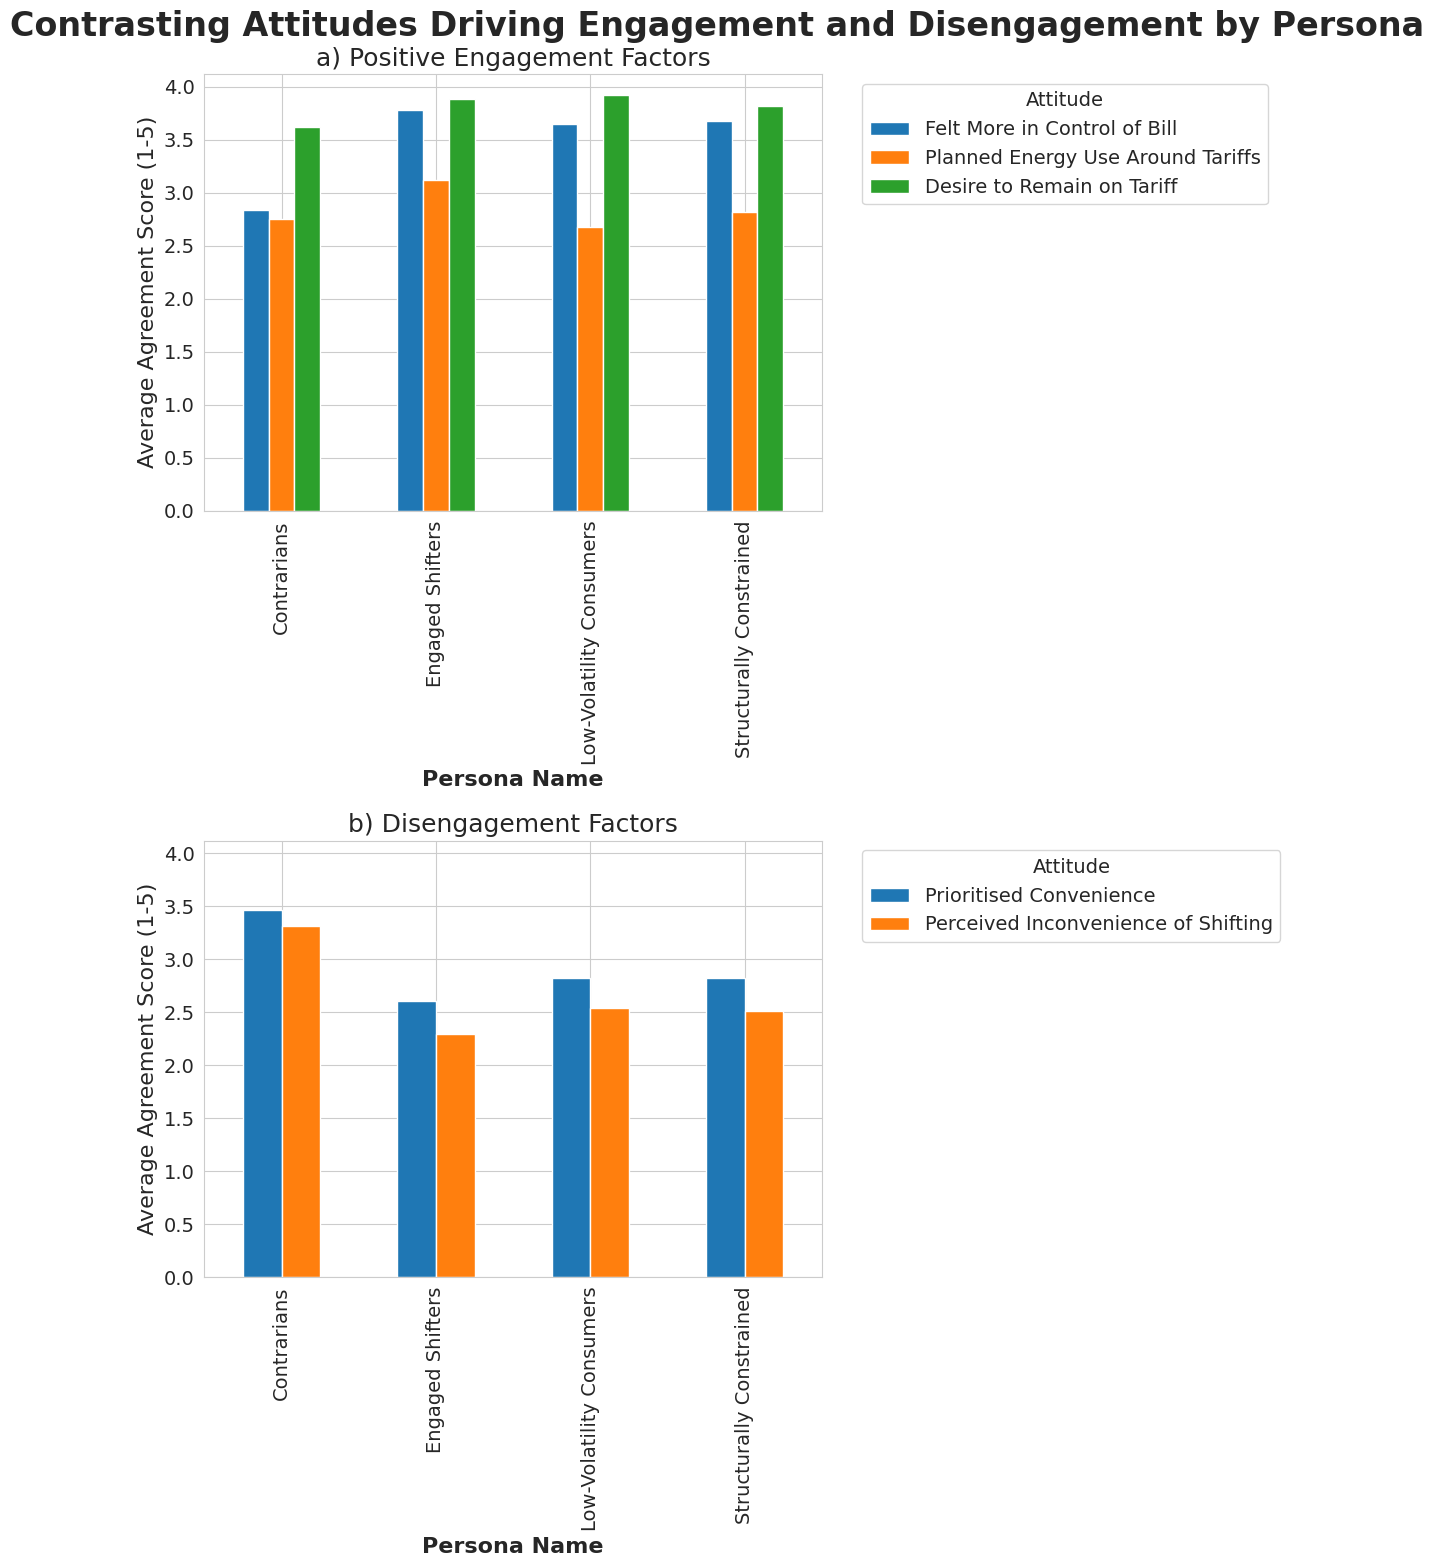

In [ ]:
# Subsection 5c: Attitude Comparison Plots
# These plots directly compare the positive and negative attitudes driving engagement.
print("\n[3] Generating Attitude Comparison plots")

# Define Positive vs. Disengagement factors
positive_factors = {
    'Felt More in Control of Bill': 'Felt More in Control of Bill',
    'Planned Energy Use Around Tariffs': 'Planned Energy Use Around Tariffs',
    'Desire to Remain on Tariff': 'Desire to Remain on Tariff'
}
disengagement_factors = {
    'Prioritised Convenience': 'Prioritised Convenience',
    'Perceived Inconvenience of Shifting': 'Perceived Inconvenience of Shifting'
}

# On top of other
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
fig.suptitle('Contrasting Attitudes Driving Engagement and Disengagement by Persona', fontsize=24, weight='bold')

# Plot Positive Engagement Factors
df.groupby('persona_name')[list(positive_factors.keys())].mean().reindex(persona_order).plot(
    kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
axes[0].set_title('a) Positive Engagement Factors', fontsize=18)
axes[0].set_ylabel('Average Agreement Score (1-5)')
axes[0].set_xlabel('Persona Name', weight='bold')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='Attitude', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Disengagement Factors
df.groupby('persona_name')[list(disengagement_factors.keys())].mean().reindex(persona_order).plot(
    kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e']
)
axes[1].set_title('b) Disengagement Factors', fontsize=18)
axes[1].set_ylabel('Average Agreement Score (1-5)')
axes[1].set_xlabel('Persona Name', weight='bold')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(title='Attitude', bbox_to_anchor=(1.05, 1), loc='upper left')

# Match y-axis limits manually
ymin = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(ymin, ymax)
axes[1].set_ylim(ymin, ymax)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.94) # Adjust top margin for the main title

plt.show()


Generating Appliance Shifting vs. Routine Rigidity plots...


/tmp/ipython-input-3590354030.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shift_data = df.groupby('persona_name')[shift_col].mean().reindex(persona_order)
/tmp/ipython-input-3590354030.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  routine_data = df.groupby('persona_name')[routine_col].mean().reindex(persona_order) * 100 # as percentage
/tmp/ipython-input-3590354030.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

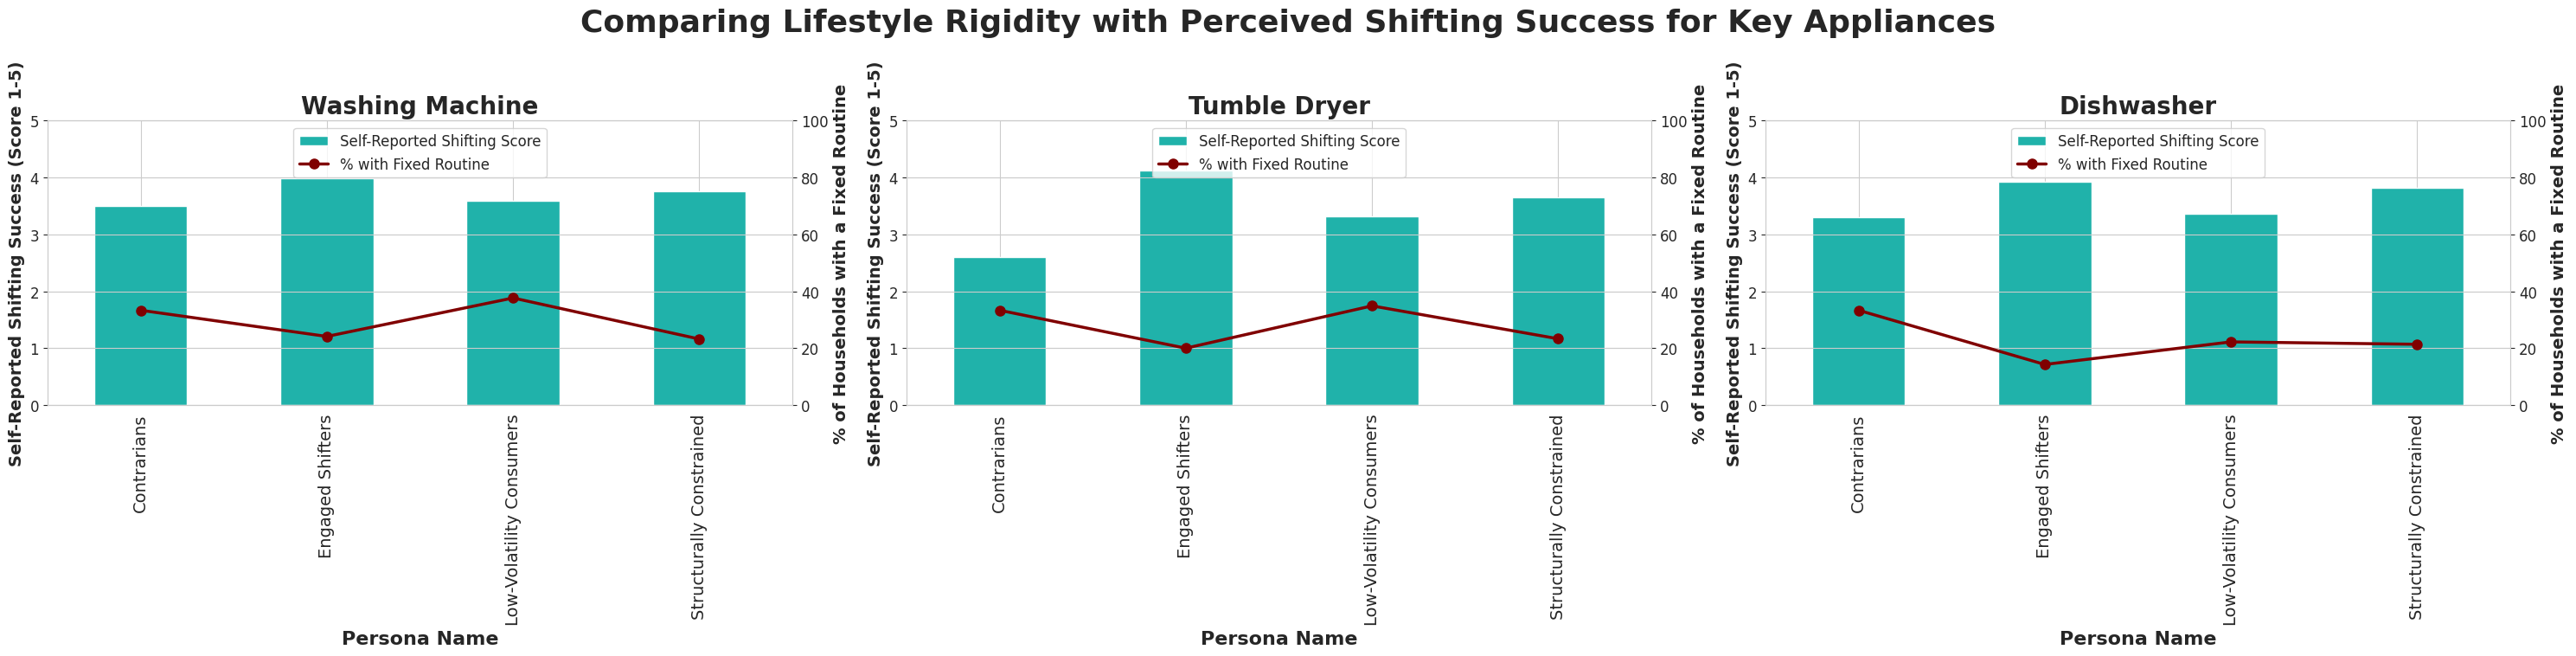

In [ ]:
# Subsection 5d: Appliance Shifting vs. Routine Rigidity
# This dual-axis plot compares self-reported shifting success (bars) against
# lifestyle rigidity (line) for key household appliances.
print("\nGenerating Appliance Shifting vs. Routine Rigidity plots")

appliances = {
    'Washing Machine': ('Self-Reported Shift of Washing Machine', 'Has Fixed Routine for Washing Machine'),
    'Tumble Dryer': ('Self-Reported Shift of Tumble Dryer', 'Has Fixed Routine for Tumble Dryer'),
    'Dishwasher': ('Self-Reported Shift of Dishwasher', 'Has Fixed Routine for Dishwasher')
}

fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=False) # Increased figure size for clarity
fig.suptitle('Comparing Lifestyle Rigidity with Perceived Shifting Success for Key Appliances', fontsize=26, weight='bold')

for i, (appliance_name, (shift_col, routine_col)) in enumerate(appliances.items()):
    ax1 = axes[i]

    # Calculate metrics
    shift_data = df.groupby('persona_name')[shift_col].mean().reindex(persona_order)
    routine_data = df.groupby('persona_name')[routine_col].mean().reindex(persona_order) * 100 # as percentage

    # Bar plot for shifting success
    shift_data.plot(kind='bar', ax=ax1, color='lightseagreen', label='Self-Reported Shifting Score', legend=False)
    ax1.set_ylabel('Self-Reported Shifting Success (Score 1-5)', fontsize=14, weight='bold')
    ax1.set_xlabel('Persona Name', weight='bold', fontsize=16)
    ax1.set_title(appliance_name, fontsize=20, weight='bold')
    ax1.tick_params(axis='x', rotation=90, labelsize=14)
    ax1.tick_params(axis='y', labelsize=12)

    # Line plot for routine rigidity on a second y-axis
    ax2 = ax1.twinx()
    routine_data.plot(kind='line', ax=ax2, color='maroon', marker='o', lw=2.5, markersize=8, label='% with Fixed Routine', legend=False)
    ax2.set_ylabel('% of Households with a Fixed Routine', fontsize=14, weight='bold')
    ax2.tick_params(axis='y', labelsize=12)

    # Set y-axis limits
    ax1.set_ylim(0, 5)
    ax2.set_ylim(0, 100)

    # Combine legends from both axes and place it on the plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    # Create the combined legend on the second axis
    ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Generating Overall Barriers and Motivations for the entire LCL Cohort...


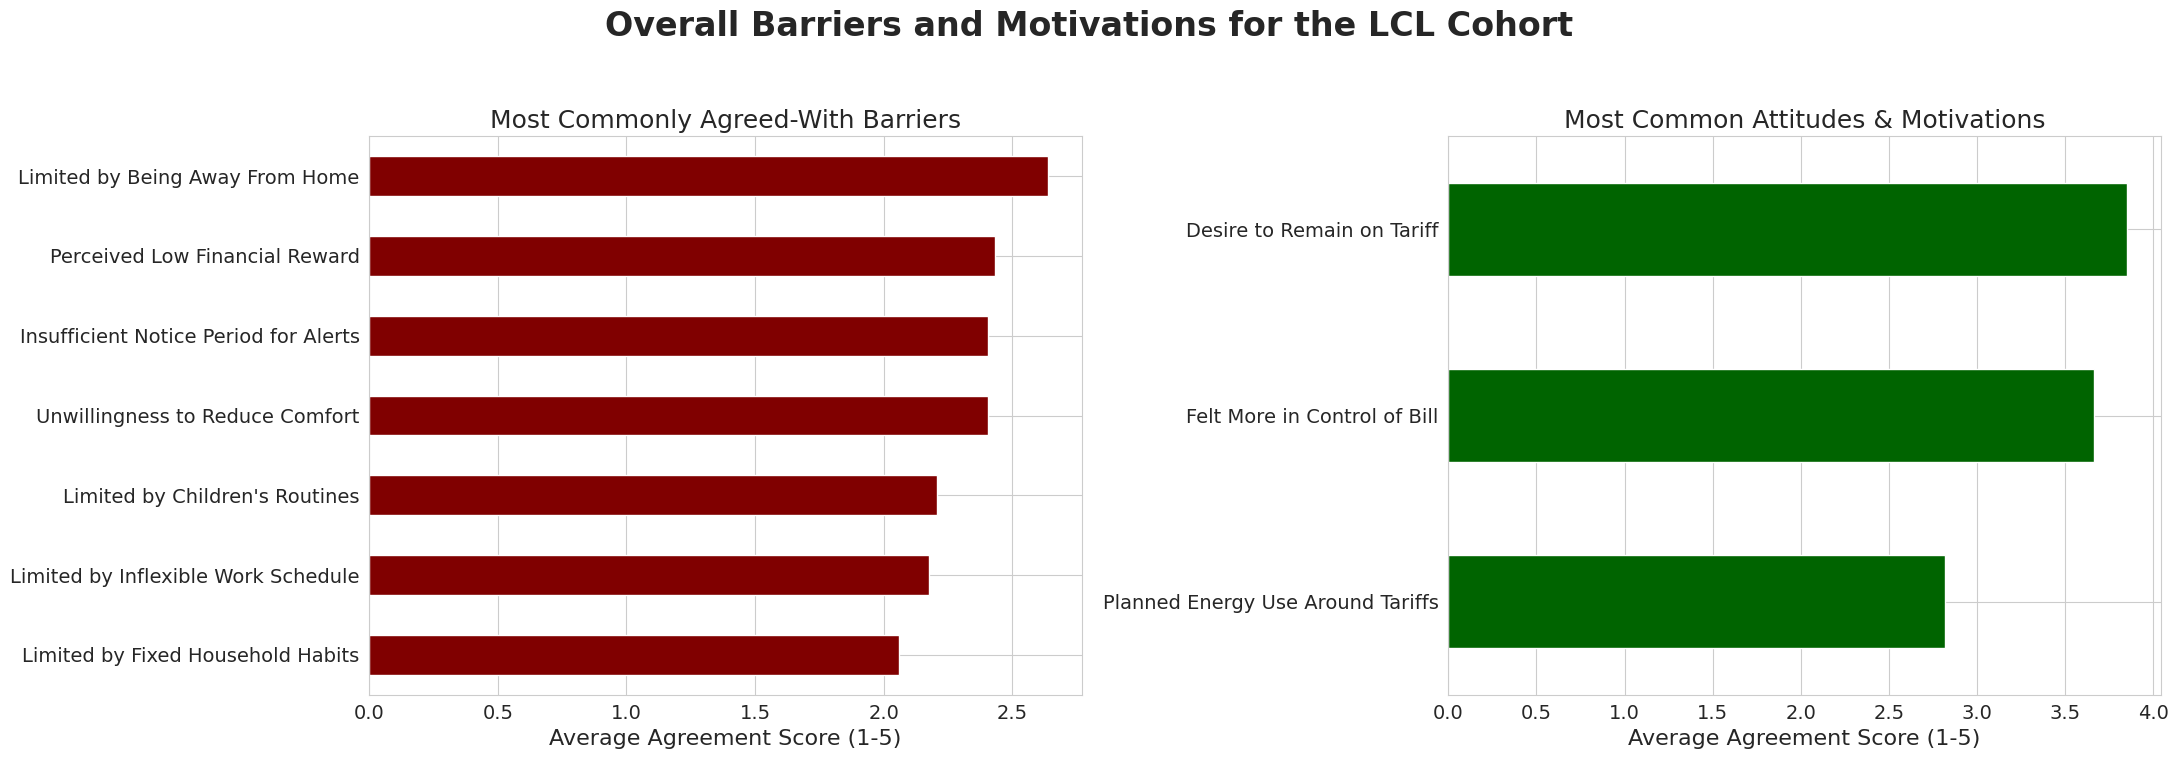

In [ ]:
# Barriers and motivations for entire cohort

print("\nGenerating Overall Barriers and Motivations for the entire LCL Cohort...")

all_attitudes = list(positive_factors.keys()) + list(disengagement_factors.keys())
all_barriers = barrier_cols

# Calculate means for the whole dataset
attitude_means = df[all_attitudes].mean().sort_values(ascending=True)
barrier_means = df[all_barriers].mean().sort_values(ascending=True)

# Separate positive and negative attitudes for plotting
positive_attitude_means = df[list(positive_factors.keys())].mean().sort_values(ascending=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('Overall Barriers and Motivations for the LCL Cohort', fontsize=24, weight='bold')

# Plot Barriers
barrier_means.plot(kind='barh', ax=axes[0], color='maroon')
axes[0].set_title('Most Commonly Agreed-With Barriers', fontsize=18)
axes[0].set_xlabel('Average Agreement Score (1-5)')

# Plot Motivations
positive_attitude_means.plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_title('Most Common Attitudes & Motivations', fontsize=18)
axes[1].set_xlabel('Average Agreement Score (1-5)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 Running final deep dive into specific demographic distributions and ranked reasons 

Generating Demographic Distribution Box Plots


/tmp/ipython-input-171580634.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


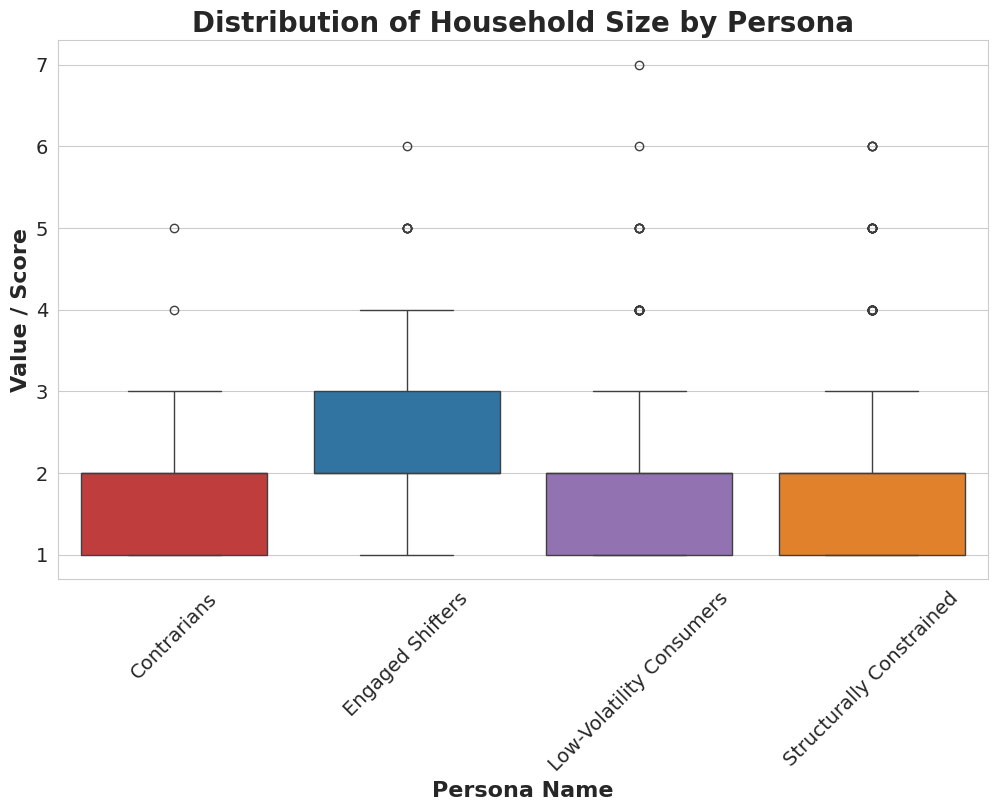

/tmp/ipython-input-171580634.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


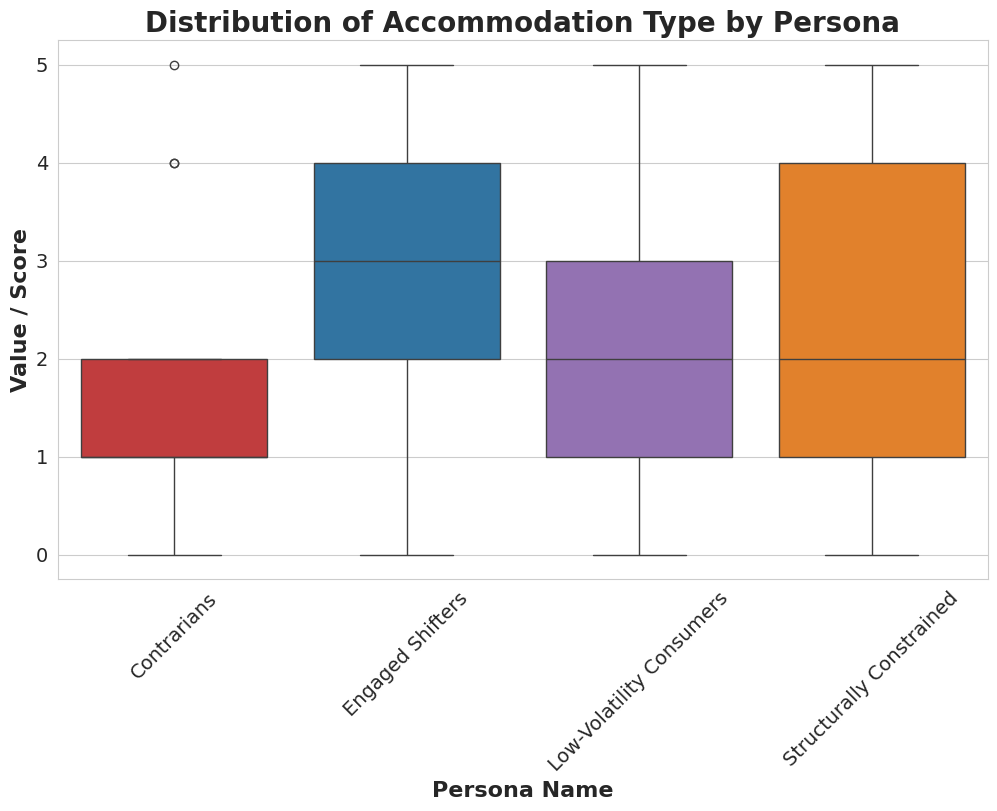


Generating Ranked Barriers and Motivations for each Persona...

DEEP DIVE FOR PERSONA: CONTRARIANS

 Top 3 Agreed-With Barriers 
Insufficient Notice Period for Alerts   3.00
Unwillingness to Reduce Comfort         2.67
Limited by Being Away From Home         2.64

 Top 3 Agreed-With Motivations 
Desire to Remain on Tariff          3.62
Felt More in Control of Bill        2.83
Planned Energy Use Around Tariffs   2.75

DEEP DIVE FOR PERSONA: ENGAGED SHIFTERS

 Top 3 Agreed-With Barriers 
Limited by Being Away From Home       2.52
Perceived Low Financial Reward        2.41
Limited by Inflexible Work Schedule   2.30

 Top 3 Agreed-With Motivations 
Desire to Remain on Tariff          3.88
Felt More in Control of Bill        3.78
Planned Energy Use Around Tariffs   3.12

DEEP DIVE FOR PERSONA: LOW-VOLATILITY CONSUMERS

 Top 3 Agreed-With Barriers 
Insufficient Notice Period for Alerts   2.74
Limited by Being Away From Home         2.63
Unwillingness to Reduce Comfort         2.49

 Top 3 A

In [ ]:
# DEEP DIVE into key demographics and ranked reasons for shifting / not

print("\n Running final deep dive into specific demographic distributions and ranked reasons ")

# Demographic box plots
# This shows the full distribution, not just the average.

print("\nGenerating Demographic Distribution Box Plots")

demographic_features_for_boxplot = {
    'Household Size': 'Distribution of Household Size by Persona',
    'Accommodation Type': 'Distribution of Accommodation Type by Persona'
}

for col, title in demographic_features_for_boxplot.items():
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)
    plt.title(title, weight='bold')
    plt.xlabel('Persona Name', weight='bold')
    plt.ylabel('Value / Score', weight='bold')
    plt.xticks(rotation=45)
    plt.show()


# Ranked barriers and motivations per persona - easy to read and interpret IF I use in my report
# This directly answers "What was the main reason?" for each group.

print("\nGenerating Ranked Barriers and Motivations for each Persona...")

barrier_cols = [
    'Limited by Being Away From Home', 'Limited by Inflexible Work Schedule',
    "Limited by Children's Routines", 'Limited by Fixed Household Habits',
    'Unwillingness to Reduce Comfort', 'Perceived Low Financial Reward',
    'Insufficient Notice Period for Alerts'
]
motivation_cols = [
    'Felt More in Control of Bill', 'Planned Energy Use Around Tariffs',
    'Desire to Remain on Tariff'
]

for persona in persona_order:
    print(f"\n" + "="*50)
    print(f"DEEP DIVE FOR PERSONA: {persona.upper()}")
    print("="*50)

    # Filter the dataframe for the current persona
    persona_df = df[df['persona_name'] == persona]

    # Calculate and print ranked barriers
    ranked_barriers = persona_df[barrier_cols].mean().sort_values(ascending=False)
    print("\n Top 3 Agreed-With Barriers ")
    print(ranked_barriers.head(3).to_string(float_format='{:.2f}'.format))

    # Calculate and print ranked motivations
    ranked_motivations = persona_df[motivation_cols].mean().sort_values(ascending=False)
    print("\n Top 3 Agreed-With Motivations ")
    print(ranked_motivations.head(3).to_string(float_format='{:.2f}'.format))
